# Ataki Dedykowane

Są to ataki, które celują w konkretny algorytm i to w nim szukają słabości. Przykładem ataku dedykowanego jest zastosowanie kryptografii różnicowej na funkcji skrótu MD5. Kryptogrfia różnicowa to zgrabne manipulowanie bitami wiadomości i sprawdzanie jak one się zmnieniają w każdej rundzie algorytmu. Manipulacje te są dopasowywane do zestawu operacji, przesunięć itp. które funkcja wykonuje. Jest to sporo pracy, ale bywa ona opłcalna.

Tym atakiem ostatecznie znaleziono kolizje w MD5, a przykładem takiej kolizji są wiadomości:


In [369]:
import hashlib
a = 0xd131dd02c5e6eec4693d9a0698aff95c2fcab58712467eab4004583eb8fb7f8955ad340609f4b30283e488832571415a085125e8f7cdc99fd91dbdf280373c5bd8823e3156348f5bae6dacd436c919c6dd53e2b487da03fd02396306d248cda0e99f33420f577ee8ce54b67080a80d1ec69821bcb6a8839396f9652b6ff72a70
b = 0xd131dd02c5e6eec4693d9a0698aff95c2fcab50712467eab4004583eb8fb7f8955ad340609f4b30283e4888325f1415a085125e8f7cdc99fd91dbd7280373c5bd8823e3156348f5bae6dacd436c919c6dd53e23487da03fd02396306d248cda0e99f33420f577ee8ce54b67080280d1ec69821bcb6a8839396f965ab6ff72a70
print(hashlib.md5(a.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())
print(hashlib.md5(b.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())

79054025255fb1a26e4bc422aef54eb4
79054025255fb1a26e4bc422aef54eb4


Porównajmy wiadomości [tym narzędziem.](https://text-compare.com/) W roku 2016 znalezienie kolizji w MD5 kosztowało około 0.65$.


In [370]:
a = 0x4dc968ff0ee35c209572d4777b721587d36fa7b21bdc56b74a3dc0783e7b9518afbfa200a8284bf36e8e4b55b35f427593d849676da0d1555d8360fb5f07fea2
b = 0x4dc968ff0ee35c209572d4777b721587d36fa7b21bdc56b74a3dc0783e7b9518afbfa202a8284bf36e8e4b55b35f427593d849676da0d1d55d8360fb5f07fea2
print(hashlib.md5(a.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())
print(hashlib.md5(b.to_bytes((a.bit_length() + 7) // 8, byteorder='big')).hexdigest())

008ee33a9d58b51cfeb425b0959121c9
008ee33a9d58b51cfeb425b0959121c9


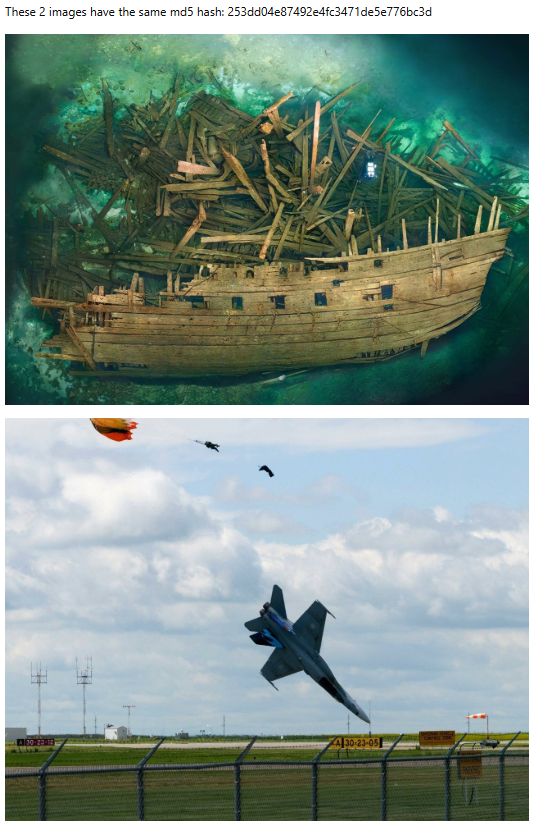


# Ataki Generyczne

Czyli ataki nie na konkretny algorytm, ale na konkretny typ algorytmu - w tym przypadku funkcję skrótu.


## Atak słownikowy

Istnieje kilka rodzajów ataków na funkcje skrótu. Najprostszym sposobem próby złamania hasza jest tzw. atak słownikowy. Polega on na tym, że mamy po prostu duży słownik danych przechowujący pary hasło - skrót. Oczywiście w takiej formie słownik będzie gigantycznym plikiem co czyni ten atak mało skutecznym. Pewnym udoskonaleniem tego ataku jest przechowywanie haseł popularnych, jak np. "admin", "123456", "abc123". Jedynym sposobem zabezpieczenia się przed słabym hasłem jest odpowiednia polityk serwisu, w którym to hasło zakładamy.


In [371]:

# Instalacja Hashcat
!apt update
!apt install -y hashcat

zsh:1: command not found: apt
zsh:1: command not found: apt


In [372]:
# Hasło, które będziemy hashować
start_password = "princess"

# Wygenerowanie hasha MD5
hash_md5 = hashlib.md5(start_password.encode()).hexdigest()
print("Hash MD5 dla hasła 'princess':", hash_md5)

Hash MD5 dla hasła 'princess': 8afa847f50a716e64932d995c8e7435a


In [373]:
# Tworzenie pliku z hashem MD5 do złamania
with open("hashes.txt", "w") as f:
    f.write("8afa847f50a716e64932d995c8e7435a")

In [374]:
# Pobranie listy słów rockyou.txt
# !wget https://github.com/brannondorsey/naive-hashcat/releases/download/data/rockyou.txt

In [375]:
!hashcat -m 0 -a 0 hashes.txt rockyou.txt --force --status  # uruchamiać bez show w razie gdy pusto pod spodem

zsh:1: command not found: hashcat


## Tęczowe tablice

A co jeśli możemy zrobić tak, że pojedynczy wpis hasło - skrót przechowuje tak naprawdę znacznie więcej par? To są właśnie tęczowe tablice. Ogólna idea jest taka, że startujemy od jakiegoś (np. losowego) hasła. Tworzymy z niego skrót, a następnie z tego skrótu tworzymy nowe hasło z wykorzystaniem tzw. funkcji redukcji. No i powtarzamy tę czynność ustaloną liczbę razy, a na końcu do słownika dodajemy parę hasło początkowe - skrót końcowy. Stwórzmy więc krok po kroku własną tęczową tablicę i spróbujmy ją wykorzystać do złamania hasła.


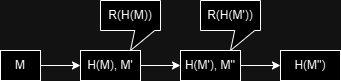


### Krok 1 - stałe

Musimy na początku ustalić kilka rzeczy, które są zależne od mocy obliczeniowej i czasu, którym dysponujemy:

1.  CHAIN_LENGTH - czyli jaka jest długość pojedynczego łancucha haszowań. Ten parametr zadecyduje ile informacji będzie przechowywał pojedynczy wpis, ale wpłynie też na szybkość obliczeń.
2.  NUM_CHAINS - czyli ile wpisów będzie przechowywała nasza tęczowa tablica. Tradeoff jest oczywisty.
3.  PASSWORD_LENGTH - czyli jakiej długości hasła rozważamy. Parametr ten wpływa także na funkcję redukcji,
4.  CHARSET - czyli jakie znaki są w haśle w ogóle dozowlone.

Ponieważ mamy ograniczony czas, proponuję następujący zestaw parametrów:


In [376]:
import string
CHAIN_LENGTH = 100
NUM_CHAINS = 50
PIN_LENGTH = 4
CHARSET = string.digits

Załóżmy też, że będziemy łamać czterocyfrowe piny.


## Krok 2 - funkcja redukcji

Czyli funkcja, która powinna przyjąć na wejściu skrót, a na wyjściu zwrócić hasło wygenerowane w oparciu o ten skrót. Z oczywistych względów nie ma żadnej "certyfikowanej" funkcji redukcji. Nikomu nie zależy na tym (a przynajmniej nie powinno), aby efektywnie łamać hasze. Mamy tu więc dowolność. Poniżej przedstawiam moją propozycję:


In [377]:
def md5(plain):
    return hashlib.md5(plain.encode()).hexdigest()

In [378]:
def reduction_func_v1(hash_str, position):
    hash_int = (int(hash_str, 16) + position) % 10000
    return f"{hash_int}".zfill(PIN_LENGTH)

Prosta funkcja, która tworzy ze skrótu liczbę i dodaje do tej liczby pozycję w łańcuchu, a następnie generuje określoną liczbę znaków z wybranego charsetu. Dorzucam jeszcze funkcję generującą hasło:


In [379]:
def generate_deterministic_password(index, length=PIN_LENGTH):
    # Przekonwertuj index na czterocyfrowy string (uzupełnij zerami od lewej w razie potrzeby, np. 0001).
    return f"{index}".zfill(length)

In [380]:
reduction_func = reduction_func_v1
hash_func = md5

## Krok 3 - generowanie tablicy

No to jesteśmy gotowi. Wygeneurj własną tęczową tablicę wg. opisanego niżej algorytmu:

1. Zainicjalizuj słownik rainbow_table.
2. Wykonuj kroki 3-8 NUM_CHAINS razy.
3. Wygeneruj hasło (wykorzystaj numer iteracji i funkcję generate_deterministic_password). Przypisz do zmiennej start_password.
4. Przypisz do zmiennej current_password wartość ze start_password.
5. Wykonuj kroki 6-7 CHAIN_LENGTH razy.
6. Wygeneruj hash z current_password i przypisz do current_hash.
7. Wygeneruj nowe hasło z wykorzystaniem funkcji redukcji oraz numeru iteracji pętli 5. Wykorzystaj reduction_function. Wynik przypisz do current_password.
8. Dodaj do słownika rainbow_table wartość start_password po kluczem current_hash.
9. Zwróć rainbow_table.


In [381]:
def generate_rainbow_table():
    rainbow_table = {}
    for i in range(NUM_CHAINS):
        start_password = generate_deterministic_password(i, length=PIN_LENGTH)
        current_password = start_password
        for c in range(CHAIN_LENGTH):
            current_hash = hash_func(current_password)
            current_password = reduction_func(current_hash, c)
        rainbow_table[current_hash] = start_password
    return rainbow_table

## Krok 4 - łamanie hasza

Mamy już wszystko czego potrzebujemy aby złamać nasz skrót. Zauważ, że każdy z naszych NUM_CHAINS wpisów musimy przeanalizować CHAIN_LENGTH razy. Czyli tak naprawdę to zredukowaliśmy rozmiar wykorzystanej pamięci kosztem wzrostu liczby obliczeń. Algorytm wyszukiwania można przedstawić następująco:


In [382]:
def lookup_in_rainbow_table(target_hash, rainbow_table):
    def get_message(start_message, searched_hash):
        current_password = start_message
        for c in range(CHAIN_LENGTH):
            current_hash = hash_func(current_password)
            if current_hash == searched_hash:
                return current_password
            current_password = reduction_func(current_hash, c)
        return None

    if (M := rainbow_table.get(target_hash, None)) is not None:
        return get_message(M, target_hash)

    for i in range(CHAIN_LENGTH-1, -1, -1):
        current_hash = target_hash
        for j in range(i, CHAIN_LENGTH):
            current_password = reduction_func(current_hash, j)
            current_hash = hash_func(current_password)
            if (M := rainbow_table.get(current_hash, None)) is not None:
                cracked = get_message(M, target_hash)
                if cracked:
                    return cracked
    return None

## Krok 5 - testy


In [383]:
rainbow_table = generate_rainbow_table()
assert len(rainbow_table) == 36

In [384]:
hash = md5("9999")
result = lookup_in_rainbow_table(hash, rainbow_table)
if result:
    print("Cracked!")
    print(md5(result))
else:
    print("Not found")

Cracked!
fa246d0262c3925617b0c72bb20eeb1d


Zwórć uwagę, że w miarę regularnie łamiemy 4 cyfrowy kod pin posiadając raptem 50 wpisów w naszym słowniku (!!!). A teraz wyobraź sobie, że w internecie są dostępne takie tablice o rozmiarach terabajtów. Dodaj do tego fakt, że po pierwsze potencjalny atakujący nie chce złamać konkretnie Twojego pinu. Atakującemu wystarczy po prostu złamanie jak największej liczby pinów.

Ok, czas na eksperymenty. Pobawmy się tym co mamy.


## Zadania

1. Napisz funkcję iterującą po wszystkich pinach od 0000 do 9999 i policz ile z nich udało Ci się złamać tęczową tablicą.
2. Wymyśl własną funkcję redukcji i ponownie wykonaj 1. Czy Twoja funkcja redukcji jest bardziej efektywna?
3. Spróbuj zwiększyć długość pinu i dostosować parametry tablicy.
4. Skorzystaj z certyfikowanych funkcji skrótu. Sprawdź, czy uda Ci się osiągnąć to samo.


In [401]:
import concurrent.futures


def check_chunk(start, end, pin_length, rainbow_table):
    cnt = 0
    cracked_pins = []
    for pin in range(start, end):
        pin_str = f"{pin}".zfill(pin_length)
        hash = hash_func(pin_str)
        result = lookup_in_rainbow_table(hash, rainbow_table)
        if result:
            cnt += 1
            print(f"Cracked {hash} to {result}")
            cracked_pins.append(pin_str)
    return cnt, cracked_pins


def check_rainbow_table_efficiency(rainbow_table, pin_length=PIN_LENGTH, num_threads=1):
    total_pins = 10**pin_length
    chunk_size = (total_pins + num_threads -
                  1) // num_threads  # ceiling division
    futures = []

    with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
        for i in range(0, total_pins, chunk_size):
            start = i
            end = min(i + chunk_size, total_pins)
            futures.append(executor.submit(check_chunk, start,
                           end, pin_length, rainbow_table))

    # Collect results
    total_count = 0
    all_cracked_pins = []
    for future in concurrent.futures.as_completed(futures):
        cnt, cracked_pins = future.result()
        total_count += cnt
        all_cracked_pins.extend(cracked_pins)

    return total_count, all_cracked_pins

In [386]:
cnt, cracked_pins = check_rainbow_table_efficiency(rainbow_table)

print(f"Cracked {cnt} passwords")

Cracked 4a7d1ed414474e4033ac29ccb8653d9b to 0000
Cracked 25bbdcd06c32d477f7fa1c3e4a91b032 to 0001
Cracked d39934ce111a864abf40391f3da9cdf5 to 0005
Cracked 6950aac2d7932e1f1a4c3cf6ada1316e to 0007
Cracked 926abae84a4bd33c834bc6b981b8cf30 to 0008
Cracked fc1198178c3594bfdda3ca2996eb65cb to 0010
Cracked ae2bac2e4b4da805d01b2952d7e35ba4 to 0011
Cracked 29150bb2319c182c944841c74d2f8d75 to 0012
Cracked c0279f73075a52e1a7dea35065bc8c80 to 0013
Cracked b6fb522815d06fed82b0140be4c74680 to 0014
Cracked 0e7e3cf0ded4d9db8b376b317c007f99 to 0015
Cracked c3f484315c27d75d5449e9e0963949da to 0016
Cracked 6858fb45a3d3aef7c29322d3b68dffd1 to 0017
Cracked 857778a20b9a41d4ca0d687a36e4bfa8 to 0018
Cracked 540bd55a2cf295b8ea9cd78650e89d03 to 0019
Cracked ecee596a242de13b779391cdaa2c528d to 0020
Cracked d9f5e405a7f74ed652a8f0b31a87f636 to 0021
Cracked 147768d3955e38c4e662c0a95d807abc to 0022
Cracked b26747fc8cb2170baa866b315cf58b7c to 0023
Cracked 096ec814d2392f379695f30ca7041977 to 0024
Cracked ed0a75eeb69b

In [387]:
def reduction_func_v2(hash_str, position):
    plaintextKey = (int(hash_str, 16) ^ position) % (
        len(CHARSET) ** PIN_LENGTH)
    plaintext = ""
    for _ in range(PIN_LENGTH):
        plaintext += CHARSET[plaintextKey % len(CHARSET)]
        plaintextKey //= len(CHARSET)
    return plaintext

In [388]:
reduction_func = reduction_func_v2

rainbow_table = generate_rainbow_table()
cnt, cracked_pins = check_rainbow_table_efficiency(rainbow_table)

print(f"Cracked {cnt} passwords")

Cracked 4a7d1ed414474e4033ac29ccb8653d9b to 0000
Cracked 25bbdcd06c32d477f7fa1c3e4a91b032 to 0001
Cracked fcd04e26e900e94b9ed6dd604fed2b64 to 0002
Cracked 7cd86ecb09aa48c6e620b340f6a74592 to 0003
Cracked 95b09698fda1f64af16708ffb859eab9 to 0004
Cracked d39934ce111a864abf40391f3da9cdf5 to 0005
Cracked 7f8bb0fe8b33780a08fe6b60ced14529 to 0006
Cracked 6950aac2d7932e1f1a4c3cf6ada1316e to 0007
Cracked 926abae84a4bd33c834bc6b981b8cf30 to 0008
Cracked fc1198178c3594bfdda3ca2996eb65cb to 0010
Cracked ae2bac2e4b4da805d01b2952d7e35ba4 to 0011
Cracked c0279f73075a52e1a7dea35065bc8c80 to 0013
Cracked b6fb522815d06fed82b0140be4c74680 to 0014
Cracked c3f484315c27d75d5449e9e0963949da to 0016
Cracked 6858fb45a3d3aef7c29322d3b68dffd1 to 0017
Cracked 857778a20b9a41d4ca0d687a36e4bfa8 to 0018
Cracked 540bd55a2cf295b8ea9cd78650e89d03 to 0019
Cracked d9f5e405a7f74ed652a8f0b31a87f636 to 0021
Cracked b26747fc8cb2170baa866b315cf58b7c to 0023
Cracked 096ec814d2392f379695f30ca7041977 to 0024
Cracked ed0a75eeb69b

In [ ]:
def sha256(password):
    return hashlib.sha256(password.encode()).hexdigest()


reduction_func = reduction_func_v2
hash_func = sha256

rainbow_table = generate_rainbow_table()
cnt, cracked_pins = check_rainbow_table_efficiency(rainbow_table)

print(f"Cracked {cnt} passwords")

Cracked 9af15b336e6a9619928537df30b2e6a2376569fcf9d7e773eccede65606529a0 to 0000
Cracked 4fac6dbe26e823ed6edf999c63fab3507119cf3cbfb56036511aa62e258c35b4 to 0002
Cracked 0591b59c1bdd9acd2847a202ddd02c3f14f9b5a049a5707c3279c1e967745ed4 to 0004
Cracked 1ed8eb363bcd64c52f5f8703ecd464008979ac2ef462e6c5df342fe56c561bd5 to 0005
Cracked 6b3b9a6ddb739ea6b3984e9038c33edeaecfb0eea476eba17b606d4699ca24e1 to 0006
Cracked f15cea39f11dc0371cfb9a4b7b1c38d5c636feb72d70e2759b0e505905ee9d01 to 0007
Cracked 0b6dfcd5427a43a60b0a38360499be09d494c8d8d67d70fc23080186e17161ba to 0008
Cracked 0b08e3dcc50fe4e5cee9b0b3a671a8db936f8335ba9050696d41cbb9a07f22e3 to 0010
Cracked a8d0b6f0939cfd883251f62b265f971ef8a5ab97eee32b91460f08b965601d93 to 0011
Cracked 84b2a5d834daee2fff7eb5e31f44ba68eb860d86d2cf8e37606a26fa775cf23b to 0012
Cracked 18303683dba5587003399c2103c2cbd8448bed6601514d9ea159a5af102e1310 to 0013
Cracked 07a8e31c03ce18180509eeb3107b8f7788f06e60b69cc91eccf6e1ec87917fc9 to 0014
Cracked 4298e3b3ed58c3af466b

In [402]:
PIN_LENGTH = 5
NUM_CHAINS = 200
CHAIN_LENGTH = 250
hash_func = md5
reduction_func = reduction_func_v2

rainbow_table = generate_rainbow_table()
cnt, cracked_pins = check_rainbow_table_efficiency(
    rainbow_table, PIN_LENGTH, num_threads=4)

print(f"Cracked {cnt} passwords")

Cracked 70f44538106c52ad2a01ffba924792e2 to 25000
Cracked 27099b1bb4f5d2f647df1faef21a5d9a to 75000
Cracked 35fafc97329b4ad6238034512f22a217 to 75001
Cracked 800c3c33154bab83b2e4f4605a4beac0 to 75002
Cracked 330add99531b6d578cc1c18e8444b10a to 25001
Cracked 09d1d2fa86fbc25c85269b522d96b9a9 to 25002
Cracked dcddb75469b4b4875094e14561e573d8 to 00000
Cracked 4c68cea7e58591b579fd074bcdaff740 to 00001
Cracked 652a805887302f460fa9d0f968fdee9d to 25003
Cracked b3998da088b9770eb22501e496b6200e to 75004
Cracked 881e6ef49e144ba881efcd79350192e4 to 75005
Cracked e08599ba76fe6afa2b5786d857b0f56e to 00003
Cracked 9cc16a0bb48e3e50c4fd9c79444b393b to 00004
Cracked e72581f8614727a152dec6fcfc739ad2 to 00005
Cracked 1b4ee40ffb4c7cf07b1d29cb65862410 to 25006
Cracked f7411247b92b5898a10b848b7c74687b to 75008
Cracked 7a77584182a904bb75558a6bc911dd6e to 00006
Cracked 3354cbe0f7e1dbc43916af419085f9c4 to 00007
Cracked d4ee60f0f9279cfa4185653c57744d7f to 00008
Cracked ff5df3fc5578f0ebf893269c16fe691a to 00009
